# Bike-count interpolation: Euclidean GP vs Graph GP (single-hour snapshot)

This notebook implements two comparable spatial interpolation analyses on the same single-hour snapshot:

1. Euclidean GP (baseline): Matérn/RBF kernel on 2D projected coordinates.
2. Graph GP (paper-style): graph Matérn kernel built from the graph Laplacian eigenpairs.

Both models:
- use the same snapshot time,
- use the same train/test split over sensor nodes,
- predict the same target (bike counts),
- are evaluated with the same metrics and plots.

Important: This is not a temporal model. We intentionally freeze time to one hour.



In [1]:
print("kernel alive")

kernel alive


In [2]:
# Core imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import osmnx as ox
import networkx as nx

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import scipy.linalg as la
from scipy.optimize import minimize

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Your project loader (as in your existing notebook)
from src.data.dataload import load_csv_folder_to_dataframe



## 1) Load & preprocess bike counter data

Assumptions (match your existing notebook):
- Raw CSVs live in `DATA_DIR`
- Columns include:
  - `domain_name` (e.g., 'Stadt Tübingen')
  - `counter_site` (counter ID)
  - `iso_timestamp` (timestamp)
  - `channels_all` (bike count)
  - `latitude`, `longitude` (counter location)



In [3]:
from pathlib import Path

DATA_DIR = "data/raw"   # adjust if needed
DOMAIN = "Stadt Ludwigsburg"

SNAPSHOT_TS = pd.Timestamp('2024-10-31 16:00:00+00:00')  # must exist after flooring to hour

df_all_path = Path("df_all.csv")

if df_all_path.exists():
    print("Loading cached dataframe from df_all.csv")
    df_loaded = pd.read_csv(df_all_path)
else:
    print("df_all.csv not found, loading raw CSV folder")
    df_loaded = load_csv_folder_to_dataframe(DATA_DIR)
    df_loaded.to_csv(df_all_path, index=False)


df_city = df_loaded[df_loaded["domain_name"] == DOMAIN].copy()
df_city["iso_timestamp"] = pd.to_datetime(df_city["iso_timestamp"], errors="coerce")
df_city = df_city.dropna(subset=["iso_timestamp"])

df_city_small = df_city[["counter_site", "iso_timestamp", "channels_all", "latitude", "longitude"]].copy()

# Freeze time to one hour:
df_city_small["ts_hour"] = df_city_small["iso_timestamp"].dt.floor("H")
df_snapshot = df_city_small[df_city_small["ts_hour"] == SNAPSHOT_TS].copy()

if df_snapshot.empty:
    raise ValueError(
        f"No rows found for SNAPSHOT_TS={SNAPSHOT_TS}. "
        "Pick a timestamp that exists in the data (after flooring to hour)."
    )

# Aggregate within the hour per counter (in case multiple rows exist)
df_obs = (
    df_snapshot
    .groupby("counter_site", as_index=False)
    .agg(
        y=("channels_all", "mean"),
        lat=("latitude", "first"),
        lon=("longitude", "first"),
    )
)

display(df_obs.head())
print("Observed counters in this snapshot:", len(df_obs))



Loading cached dataframe from df_all.csv


C:\Users\Crabsi\AppData\Local\Temp\ipykernel_15232\2552578026.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_city_small["ts_hour"] = df_city_small["iso_timestamp"].dt.floor("H")


,counter_site,y,lat,lon
0,Aldinger Straße,24.0,48.883139,9.210566
1,Alleenstraße,150.0,48.893189,9.192943
2,Bismarckstraße,60.0,48.899039,9.181309
3,Bottwartalstraße,58.0,48.903483,9.198207
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430


Observed counters in this snapshot: 15


In [4]:
# REMOVE this later: Selecting available timestamps

# Ensure timestamps are parsed
df_loaded["iso_timestamp"] = pd.to_datetime(df_loaded["iso_timestamp"], errors="coerce")

# Floor to hour exactly as in the pipeline
df_loaded["ts_hour"] = df_loaded["iso_timestamp"].dt.floor("H")

# Restrict to your domain
df_city = df_loaded[df_loaded["domain_name"] == DOMAIN]

# List unique hours, sorted
unique_hours = (
    df_city["ts_hour"]
    .dropna()
    .sort_values()
    .unique()
)

print("Number of unique hourly snapshots:", len(unique_hours))
print("First 10:", unique_hours[:10])
print("Last 10:", unique_hours[-10:])


C:\Users\Crabsi\AppData\Local\Temp\ipykernel_15232\1601258778.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_loaded["ts_hour"] = df_loaded["iso_timestamp"].dt.floor("H")


Number of unique hourly snapshots: 70852
First 10: <DatetimeArray>
['2017-09-26 22:00:00+00:00', '2017-09-27 06:00:00+00:00',
 '2017-09-27 07:00:00+00:00', '2017-09-27 08:00:00+00:00',
 '2017-09-27 09:00:00+00:00', '2017-09-27 10:00:00+00:00',
 '2017-09-27 11:00:00+00:00', '2017-09-27 12:00:00+00:00',
 '2017-09-27 13:00:00+00:00', '2017-09-27 14:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]
Last 10: <DatetimeArray>
['2025-10-31 12:00:00+00:00', '2025-10-31 13:00:00+00:00',
 '2025-10-31 14:00:00+00:00', '2025-10-31 15:00:00+00:00',
 '2025-10-31 16:00:00+00:00', '2025-10-31 17:00:00+00:00',
 '2025-10-31 18:00:00+00:00', '2025-10-31 19:00:00+00:00',
 '2025-10-31 20:00:00+00:00', '2025-10-31 21:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]


## 2) Build the road/bike graph and map counters to nearest graph nodes

We:
1. Build an OSMnx bike graph within a radius.
2. Map each counter coordinate to the nearest graph node.
3. Project the graph to a metric CRS for Euclidean-distance kernels.



In [5]:
from osmnx import simplify_graph

GRAPH_RADIUS_M = 2000  # adjust to cover all counters you care about

center = (df_obs["lat"].mean(), df_obs["lon"].mean())

# Build graph in lat/lon
G_ll = ox.graph_from_point(center, dist=GRAPH_RADIUS_M, network_type="bike")

# Keep the largest strongly connected component (helps with graph kernels/distances)
largest_scc = max(nx.strongly_connected_components(G_ll), key=len)
G_ll = G_ll.subgraph(largest_scc).copy()

# Map each counter to nearest node in the lat/lon graph
df_obs["node_id"] = df_obs.apply(
    lambda r: ox.distance.nearest_nodes(G_ll, X=r["lon"], Y=r["lat"]),
    axis=1
)

# Drop counters that map outside the graph (rare, but can happen near boundary)
df_obs = df_obs[df_obs["node_id"].isin(G_ll.nodes)].copy()
print("Counters kept after node mapping:", len(df_obs))

# Project graph to metric CRS (UTM). Node IDs remain the same.
G = ox.project_graph(G_ll)
print("Projected CRS:", G.graph.get("crs"))

# protect train & test nodes BEFORE simplification
protect_nodes = set(df_obs["node_id"])

# Projected node coordinates (meters)
node_xy = pd.DataFrame(
    {
        "node_id": list(G.nodes()),
        "x": [G.nodes[n]["x"] for n in G.nodes()],
        "y": [G.nodes[n]["y"] for n in G.nodes()],
    }
)

df_obs = df_obs.merge(node_xy, on="node_id", how="left")
display(df_obs.head())

# check how many nodes the graph has
print("Number of nodes in the graph:", len(G.nodes()))



Counters kept after node mapping: 15
Projected CRS: EPSG:32632


,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06


Number of nodes in the graph: 3737


## 3) One fixed train/test split over observed counters

This split is reused for both models to ensure a fair comparison.



In [6]:
RANDOM_SEED = 46
N_TRAIN = 13  # paper uses 250; we have fewer counters

rng = np.random.default_rng(RANDOM_SEED)

n_obs = len(df_obs)
if n_obs < 4:
    raise ValueError(f"Need at least 4 observed counters for a meaningful split, got {n_obs}.")

n_train = min(N_TRAIN, n_obs - 1)  # keep at least 1 test point
train_rows = rng.choice(n_obs, size=n_train, replace=False)
is_train = np.zeros(n_obs, dtype=bool)
is_train[train_rows] = True

train_df = df_obs.iloc[is_train].copy()
test_df  = df_obs.iloc[~is_train].copy()

print(f"Train counters: {len(train_df)} | Test counters: {len(test_df)}")

print(df_obs.columns)
display(df_obs.head())

y_train = train_df["y_x"].to_numpy(dtype=float)
y_test  = test_df["y_x"].to_numpy(dtype=float)

# standardize the targets (important for GP optimization)
y_mean = y_train.mean()
y_std  = y_train.std()

y_train_std = (y_train - y_mean) / y_std
y_test_std  = (y_test  - y_mean) / y_std



Train counters: 13 | Test counters: 2
Index(['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y'], dtype='object')


,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06


In [7]:
display(df_obs)

,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06
5,Fuchshof,62.0,48.890275,9.219911,269466187,516189.086309,5.415291e+06
6,Kesseläcker (Verl. Nussackerweg),18.0,48.901772,9.171905,277767167,512599.071543,5.416559e+06
7,Königinallee,34.0,48.884836,9.206656,9006691822,515170.192129,5.414693e+06
8,Marbacher Straße - Favoritepark,99.0,48.902492,9.195814,9087901877,514351.113718,5.416638e+06
9,Marbacher Straße - Neckarbrücke,21.0,48.907326,9.219096,2070675484,516046.407403,5.417173e+06


## 4) Model A: Euclidean GP on projected coordinates

Input:
- X = (x, y) projected meters

Target:
- y = bike count at the chosen snapshot hour



In [8]:
print("train_df columns:", list(train_df.columns))
print("df_obs columns:", list(df_obs.columns))
print("node_xy columns:", list(node_xy.columns))


train_df columns: ['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y']
df_obs columns: ['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y']
node_xy columns: ['node_id', 'x', 'y']


In [9]:
X_train_euc = train_df[["x", "y_y"]].to_numpy(dtype=float)
X_test_euc  = test_df[["x", "y_y"]].to_numpy(dtype=float)

# Kernel: Constant * Matérn + White noise
kernel_euc = (
    ConstantKernel(1.0, (1e-3, 1e3)) *
    Matern(length_scale=200.0, nu=1.5) +
    WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e3))
)

gp_euc = GaussianProcessRegressor(
    kernel=kernel_euc,
    alpha=0.0,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=RANDOM_SEED
)

gp_euc.fit(X_train_euc, y_train)

pred_mean_euc, pred_std_euc = gp_euc.predict(X_test_euc, return_std=True)

rmse_euc = np.sqrt(mean_squared_error(y_test, pred_mean_euc))
mae_euc  = mean_absolute_error(y_test, pred_mean_euc)


print("Euclidean GP kernel after fit:")
print(gp_euc.kernel_)
print(f"Euclidean GP  RMSE={rmse_euc:.3f}  MAE={mae_euc:.3f}")



Euclidean GP kernel after fit:
0.792**2 * Matern(length_scale=613, nu=1.5) + WhiteKernel(noise_level=0.407)
Euclidean GP  RMSE=14.933  MAE=12.029


## 5) Model B: Graph GP on the network

### 5.1) Build Laplacian and compute Eigenpairs
We build a weighted adjacency W:
- edge weight = inverse edge length (paper-style)

Then the normalized symmetric Laplacian:
- $L_{sym} = I - D^{-1/2} W D^{-1/2}$

We approximate the graph kernel with the smallest RANK eigenpairs of L_sym (we chose the lowest 5%).



In [144]:
# build node indexing
nodes = list(G.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
n_nodes = len(nodes)

# weighted adjacency W
rows, cols, data = [], [], []
for u, v, attr in G.edges(data=True):
    length = attr.get("length", None)
    if length is None or length <= 0:
        continue
    w = 1.0 / float(length) ## inverse length weight
    iu, iv = node_to_idx[u], node_to_idx[v]
    rows += [iu, iv]
    cols += [iv, iu]
    data += [w, w]

# construct sparse adjacency matrix
W = sp.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes)).tocsr()
deg = np.asarray(W.sum(axis=1)).ravel()
D_inv_sqrt = sp.diags(np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0))

# normalized symmetric graph laplacian
L_sym = sp.eye(n_nodes, format="csr") - D_inv_sqrt @ W @ D_inv_sqrt

# compute eigenpairs
RANK = min(int(np.floor(0.05 * len(G.nodes()))), n_nodes - 2) ## 5% of nodes
evals, evecs = eigsh(L_sym, k=RANK, which="SM")
evals = np.maximum(evals, 0.0)

print("Eigenpairs computed:", evecs.shape)


Eigenpairs computed: (3737, 186)


### 5.2) Build Kernel Filters (Matérn & Laplacian) & optimize Hyperparameters using GP Marginal Likelihood

Graph Diffusion filter:
- $\Phi(\lambda) = \exp(-\frac{\kappa^2}{4}\lambda)$

Graph Matérn spectral filter:
- $\Phi(\lambda) = (\frac{2\nu}{\kappa^2}+\lambda)^{-\nu}$
We keep $\nu$ fixed (you can change it).
Graph Matérn spectral filter did not yield any good results so we took diffusion (maybe due to very few training data).

We optimize hyperparameters by maximizing the GP marginal likelihood:
- $\kappa$ (length scale on the graph)
- $\sigma^2$ (variance)
- $\varsigma^2$ (noise variance)

When freely optimizing all 3 parameters $\sigma^2 \rightarrow 0$, so we settled on fixing it to 1 and optimizing only $\kappa$ and $\varsigma^2$.

MAYBE PUT ALL THE K = ZZt up here because Marginal Likelihood uses it? idk

In [145]:
# indices for training/test nodes
train_node_idx = np.array([node_to_idx[n] for n in train_df["node_id"]], dtype=int)
test_node_idx  = np.array([node_to_idx[n] for n in test_df["node_id"]], dtype=int)

# diffusion kernel feature matrix
def build_Z(kappa: float, sigma2: float) -> np.ndarray:
    
    phi = np.exp(-(kappa**2/4.0) * evals)
    
    Z = (evecs * np.sqrt(phi)[None, :]) * np.sqrt(sigma2)
    return Z

# matern kernel feature matrix (this does not work as well as diffusion)
nu_fixed = 1.5
def build_Z_matern(kappa: float, sigma2: float, nu: float) -> np.ndarray:
    
    phi = (2.0 * nu / (kappa**2) + evals) ** (-nu)
    
    Z = evecs * np.sqrt(phi)[None, :] * np.sqrt(sigma2)
    return Z



In [146]:
## NEGATIVE LOG MARGINAL LIKELIHOOD OPTIMIZATION ##
# define nll optimization for all 3 parameters
def neg_log_marginal_likelihood(params_log: np.ndarray) -> float:
    # params_log = [log_kappa, log_sigma2, log_noise_std]
    log_kappa, log_sigma2, log_noise = params_log
    kappa = np.exp(log_kappa)
    sigma2 = np.exp(log_sigma2)
    noise = np.exp(log_noise)

    Z = build_Z(kappa, sigma2)
    Ztr = Z[train_node_idx, :]

    K = Ztr @ Ztr.T
    K[np.diag_indices_from(K)] += noise**2 + 1e-8

    try:
        L = la.cholesky(K, lower=True, check_finite=False)
    except la.LinAlgError:
        return np.inf

    alpha = la.cho_solve((L, True), y_train_std, check_finite=False)

    n = len(y_train_std)
    nll = 0.5 * (y_train_std @ alpha) + np.sum(np.log(np.diag(L))) + 0.5 * n * np.log(2*np.pi)
    return float(nll)

# define nll optimization for kappa only, fixing sigma2 and noise
sigma2_fixed = 1.0
noise_fixed = 0.3
def nll_only_kappa(log_kappa):
    kappa = np.exp(log_kappa[0])

    Z = build_Z(kappa, sigma2_fixed)
    Ztr = Z[train_node_idx]

    K = Ztr @ Ztr.T
    K[np.diag_indices_from(K)] += noise_fixed**2 + 1e-8

    try:
        L = la.cholesky(K, lower=True, check_finite=False)
    except la.LinAlgError:
        return np.inf

    alpha = la.cho_solve((L, True), y_train_std, check_finite=False)

    n = len(y_train_std)
    nll = 0.5 * (y_train_std @ alpha) + np.sum(np.log(np.diag(L))) + 0.5 * n * np.log(2*np.pi)
    return float(nll)


# define nll optimization for kappa and noise, fixing sigma2
def nll_kappa_noise(log_params):
    log_kappa, log_noise = log_params
    kappa = np.exp(log_kappa)
    noise = np.exp(log_noise)

    Z = build_Z(kappa, sigma2_fixed)
    Ztr = Z[train_node_idx, :]

    K = Ztr @ Ztr.T
    K[np.diag_indices_from(K)] += noise**2 + 1e-8

    try:
        L = la.cholesky(K, lower=True, check_finite=False)
    except la.LinAlgError:
        return np.inf

    alpha = la.cho_solve((L, True), y_train_std, check_finite=False)

    n = len(y_train_std)
    nll = 0.5 * (y_train_std @ alpha) + np.sum(np.log(np.diag(L))) + 0.5 * n * np.log(2*np.pi)
    return float(nll)

# optimize all 3 parameters
x0 = np.log([0.03, 1.0, 0.1])
res_3param = minimize(neg_log_marginal_likelihood, x0=x0, method="L-BFGS-B", options={"maxiter": 500})
print("Optimization success:", res_3param.success, "|", res_3param.message)
kappa_hat3p, sigma2_hat3p, noise_hat3p = np.exp(res_3param.x)
print(f"Fitted graph GP params for all 3 params: kappa={kappa_hat3p:.4g}, sigma2={sigma2_hat3p:.4g}, noise_std={noise_hat3p:.4g}")

# optimize kappa only
res_1param = minimize(nll_only_kappa, x0=np.log([0.03]), method="L-BFGS-B", options={"maxiter": 500})
print("Optimization success:", res_1param.success, "|", res_1param.message)
kappa_hat1p = np.exp(res_1param.x[0])
print(f"Fitted graph GP params for 1 param: kappa={kappa_hat1p:.4g}, sigma2={sigma2_fixed:.4g}, noise_std={noise_fixed:.4g}")

# optimize kappa and noise
res_2param = minimize(nll_kappa_noise, x0=np.log([0.03, 0.5]), method="L-BFGS-B", options={"maxiter": 500})
print("Optimization success:", res_2param.success, "|", res_2param.message)
kappa_hat2p, noise_hat2p = np.exp(res_2param.x)
print(f"Fitted graph GP params for 2 params: kappa={kappa_hat2p:.4g}, sigma2={sigma2_fixed:.4g}, noise_std={noise_hat2p:.4g}")



Optimization success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Fitted graph GP params for all 3 params: kappa=0.03, sigma2=2.113e-05, noise_std=1
Optimization success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Fitted graph GP params for 1 param: kappa=0.01104, sigma2=1, noise_std=0.3
Optimization success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Fitted graph GP params for 2 params: kappa=0.03, sigma2=1, noise_std=0.9922


### 5.3) Prediction on Test Nodes

We use optimized $\kappa, \varsigma^2$ and fixed $\sigma^2$ to compute the Diffusion Kernel Feature Matrix $Z$.

Next, compute low rank approximation of Kernel

$K_{xx} \approx Z_xZ_x^\top$
where
$Z_x = \sqrt{\sigma^2} \, U \, \sqrt{\Phi(\Lambda)}$

Here, $U$ are the eigenvectors of the graph Laplacian $\Delta$, $\Lambda = \text{diag}(\lambda_1, \dots, \lambda_R)$ are the corresponding eigenvalues, and the spectral weights are defined as
- $\Phi(\lambda_s) = \exp\Big(-\frac{\kappa^2}{4} \lambda_s \Big), \quad s = 1, \dots, R$

So the low-rank kernel approximation can be written as
- $K_{xx} \approx Z Z^\top = \sigma^2 \, U \, \Phi(\Lambda) \, U^\top$
with $\sigma^2 = 1$

For prediction we need to solve for
- $\alpha = (K_{xx} + \varsigma^2I)^{-1}y_{train}$

Since $K_{xx}$ is small ($13 \times 13$) in our case, we compute $\alpha$ efficiently using a Cholesky decomposition:
- $K_{xx} + \varsigma^2 I = L L^\top, \quad \alpha = L^{-\top} (L^{-1} y_{\text{train}})$


The predictive mean can be computed as:
- $\mu_* = (K_{*x} \alpha)y_{sd} + y_{mean}$ with $K_{*x} = Z_*Z_x^\top$

The predictive variance (latent) can be computed as:
- $\mathrm{Var}[f_*] = \mathrm{diag}(K_{**}) - \mathrm{diag}\Big( K_{*x} (K_{xx} + \sigma_n^2 I)^{-1} K_{*x}^\top \Big)$,

where $K_{**} = Z_* Z_*^\top$ is the kernel matrix at test nodes. Using the Cholesky decomposition $K_{xx} + \sigma_n^2 I = L L^\top$, this can be efficiently computed as
- $v = L^{-1} K_{*x}^\top, \qquad
\mathrm{Var}[f_*] \approx \sum_{s=1}^d (Z_{*s})^2 - \sum_{s=1}^R v_s^2$

The predictive standard deviation can be computed as:
- $\sigma_* = (\mathrm{Var}[f_*]+ \varsigma^2) y_{sd}$



In [147]:
# Predict on test nodes
kappa = kappa_hat2p ## this is for 2 fixed params, choose kappa = kappa_hat1p or kappa_hat3p for other options
sigma2 = sigma2_fixed ## this is fixed for 1 and 2 param options, choose sigma2 = sigma2_hat3p for 3 param option
noise = noise_hat2p ## this is for 2 fixed params, choose noise = noise_hat3p for 3 param option or noise = noise_fixed for 1 param option
Z = build_Z(kappa, sigma2)
Ztr = Z[train_node_idx, :]
Zte = Z[test_node_idx, :]

# build Ktr (Kxx)
Ktr = Ztr @ Ztr.T
# Kxx += σₙ²I
Ktr[np.diag_indices_from(Ktr)] += noise**2 + 1e-8

L = la.cholesky(Ktr, lower=True, check_finite=False)
alpha = la.cho_solve((L, True), y_train_std, check_finite=False)
# alpha = (Kxx + σₙ² I)⁻¹ y 

# build Kte_tr (Kx*)
Kte_tr = Zte @ Ztr.T

# predictive mean
pred_mean_graph_std = Kte_tr @ alpha

# predictive varianc
Kte_diag = np.sum(Zte**2, axis=1)
v = la.solve_triangular(L, Kte_tr.T, lower=True, check_finite=False)
pred_var_graph = np.maximum(0.0, Kte_diag - np.sum(v*v, axis=0))
pred_std_graph_std = np.sqrt(pred_var_graph + noise**2)

pred_mean_graph = pred_mean_graph_std * y_std + y_mean
pred_std_graph  = pred_std_graph_std * y_std

rmse_graph = np.sqrt(mean_squared_error(y_test, pred_mean_graph))
mae_graph  = mean_absolute_error(y_test, pred_mean_graph)


print(f"Graph GP      RMSE={rmse_graph:.3f}  MAE={mae_graph:.3f}")



Graph GP      RMSE=19.398  MAE=14.023


## 6) Comparison plots (test nodes)



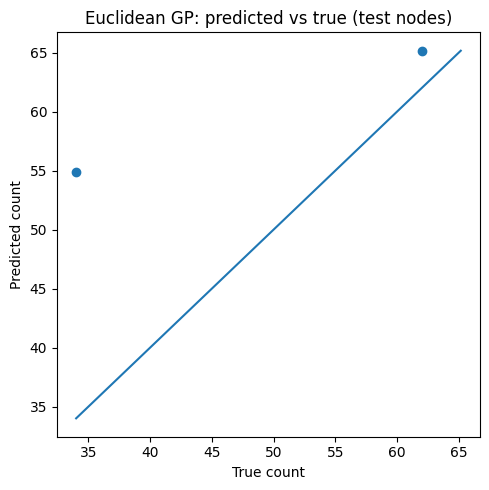

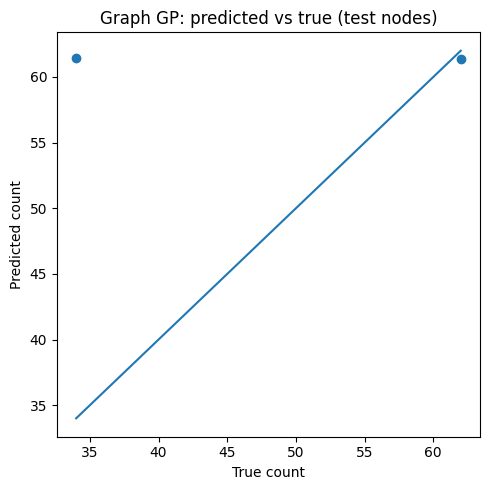

,counter_site,y_y,resid_euc,resid_graph
5,Fuchshof,5.415291e+06,3.179924,-0.620421
7,Königinallee,5.414693e+06,20.877282,27.425508


In [148]:
def scatter_pred_vs_true(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True count")
    plt.ylabel("Predicted count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

scatter_pred_vs_true(y_test, pred_mean_euc, "Euclidean GP: predicted vs true (test nodes)")
scatter_pred_vs_true(y_test, pred_mean_graph, "Graph GP: predicted vs true (test nodes)")

test_plot = test_df.copy()
test_plot["resid_euc"] = pred_mean_euc - y_test
test_plot["resid_graph"] = pred_mean_graph - y_test

display(test_plot[["counter_site","y_y","resid_euc","resid_graph"]].head())



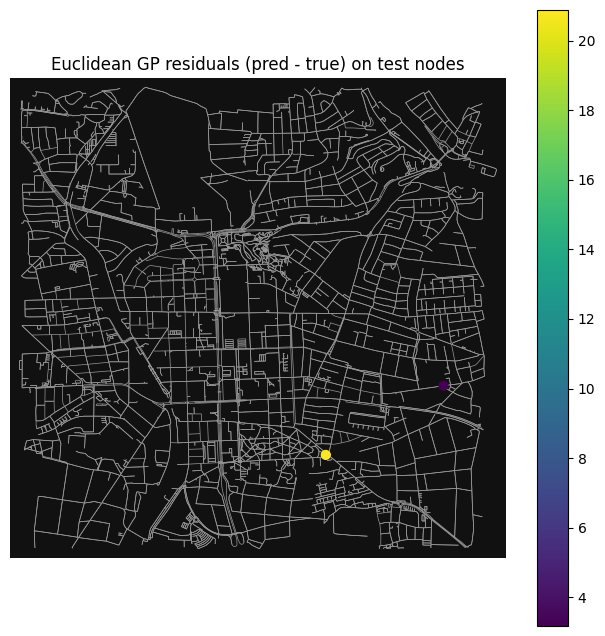

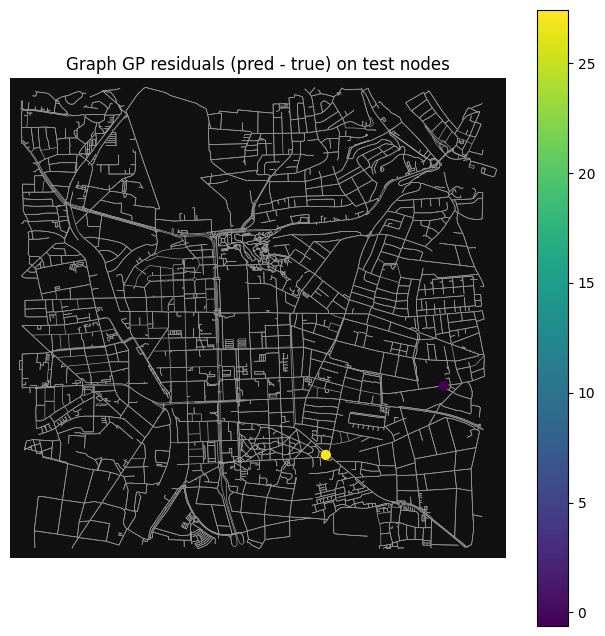

In [149]:
# Residual maps on the graph (test nodes only)
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(test_plot["x"], test_plot["y_y"], c=test_plot["resid_euc"], s=40)
plt.colorbar(sc, ax=ax)
ax.set_title("Euclidean GP residuals (pred - true) on test nodes")
plt.show()

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(test_plot["x"], test_plot["y_y"], c=test_plot["resid_graph"], s=40)
plt.colorbar(sc, ax=ax)
ax.set_title("Graph GP residuals (pred - true) on test nodes")
plt.show()



## 7) Optional: full-field maps (all nodes)

In 5) we only predicted on our two test nodes. If we want to predict mean and standard deviation on all nodes, we do not use $K_{*x}$ but $K_{all,x}$ (computation is the same as above).

We cannot plot residuals (as we do not have counts on all nodes), but we can plot a general prediction.

In [150]:
# Euclidean GP predictions at all nodes
mean_all_euc, std_all_euc = gp_euc.predict(node_xy[["x","y"]].to_numpy(dtype=float), return_std=True)

# Graph GP predictions at all nodes
all_node_idx = np.array([node_to_idx[n] for n in node_xy["node_id"]], dtype=int)
Zall = Z[all_node_idx, :]
Kall_tr = Zall @ Ztr.T

# predictive mean for all nodes
mean_all_graph = Kall_tr @ alpha

# predictive variance, std for all nodes
Kall_diag = np.sum(Zall**2, axis=1)
vall = la.solve_triangular(L, Kall_tr.T, lower=True, check_finite=False)
var_all_graph = np.maximum(0.0, Kall_diag - np.sum(vall*vall, axis=0))
std_all_graph = np.sqrt(var_all_graph + noise**2)

# prepare dataframe for plotting
node_xy_plot = node_xy.copy()
node_xy_plot["mean_euc"] = mean_all_euc
node_xy_plot["std_euc"] = std_all_euc
node_xy_plot["mean_graph"] = mean_all_graph
node_xy_plot["std_graph"] = std_all_graph

# unstandardize graph GP predictions
node_xy_plot["mean_graph_orig"] = node_xy_plot["mean_graph"] * y_std + y_mean
print(node_xy_plot["mean_graph_orig"].head())
node_xy_plot["std_graph_orig"]  = node_xy_plot["std_graph"] * y_std

0    61.383857
1    61.383134
2    61.384038
3    61.379139
4    61.378765
Name: mean_graph_orig, dtype: float64


### 7.1) Plot predicted Mean

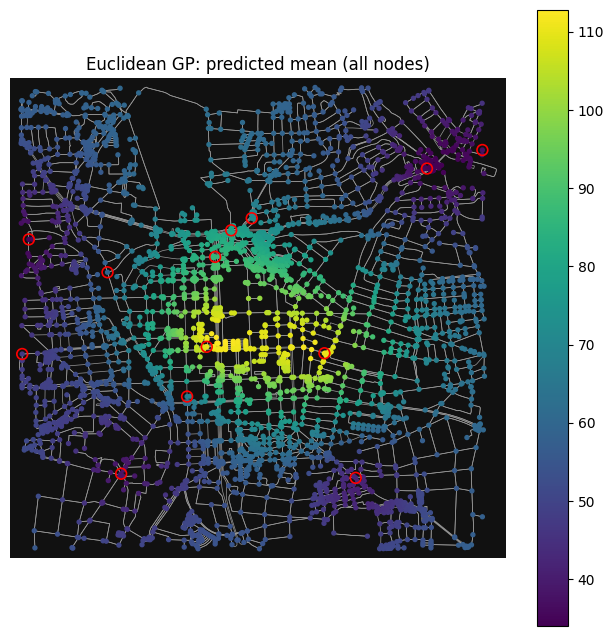

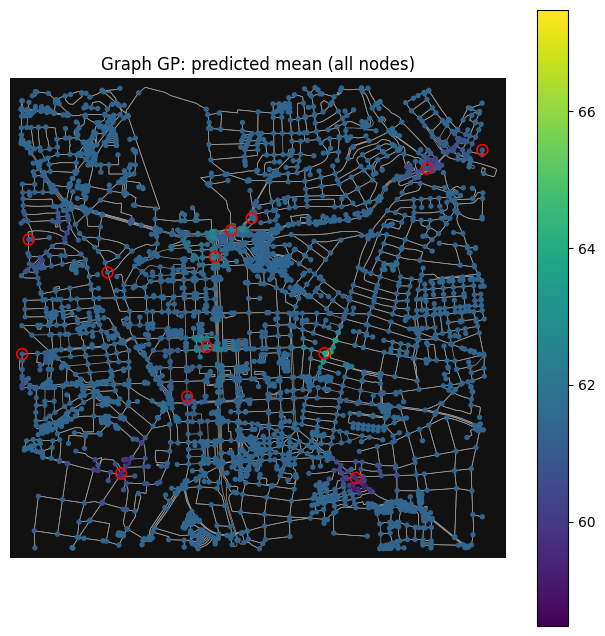

In [151]:
# plot predicted mean (all nodes)
# for euclidean GP
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["mean_euc"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Euclidean GP: predicted mean (all nodes)")
plt.show()

# for graph GP
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["mean_graph_orig"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Graph GP: predicted mean (all nodes)")
plt.show()


### 7.2) Plot predicted Standard Deviation (Uncertainty)

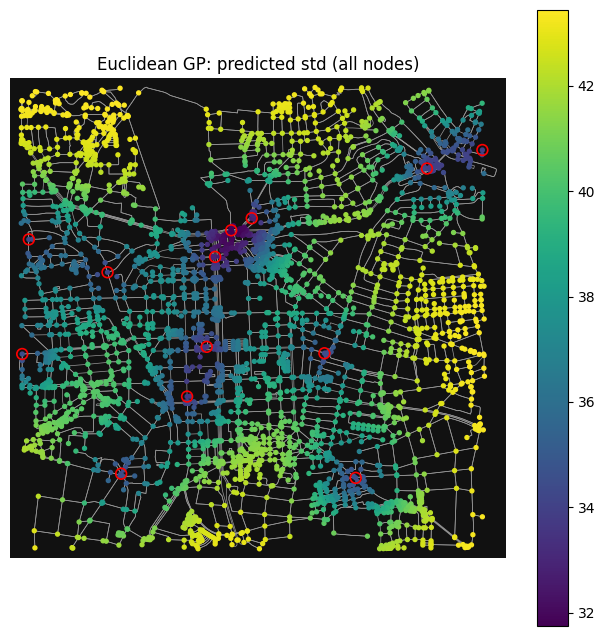

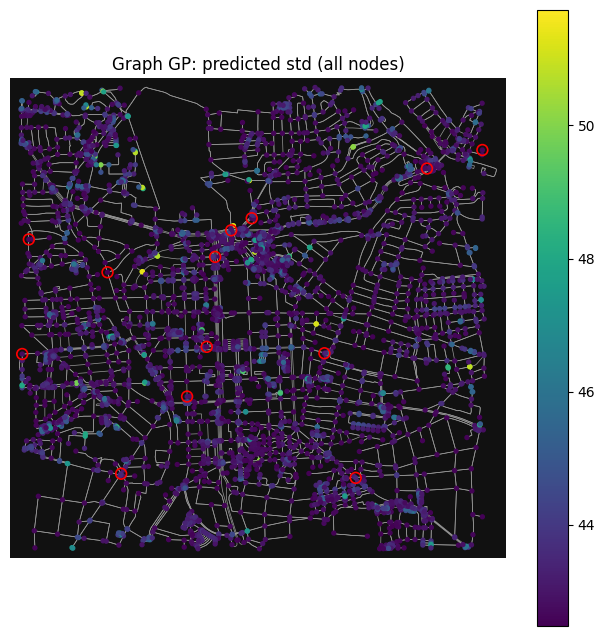

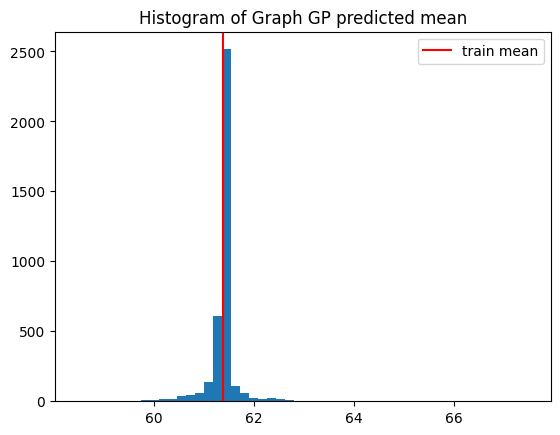

In [152]:
# plot predicted uncertainty (all nodes)
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["std_euc"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Euclidean GP: predicted std (all nodes)")
plt.show()

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)
sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["std_graph_orig"], s=8)
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)
plt.colorbar(sc, ax=ax)
ax.set_title("Graph GP: predicted std (all nodes)")
plt.show()

plt.hist(node_xy_plot["mean_graph_orig"], bins=50)
plt.axvline(y_train.mean(), color="red", label="train mean")
plt.legend()
plt.title("Histogram of Graph GP predicted mean")
plt.show()

### Optional: Top 20 Nodes for Euclidean/ Graph GP

We can also show the nodes with highest uncertainty for both models.

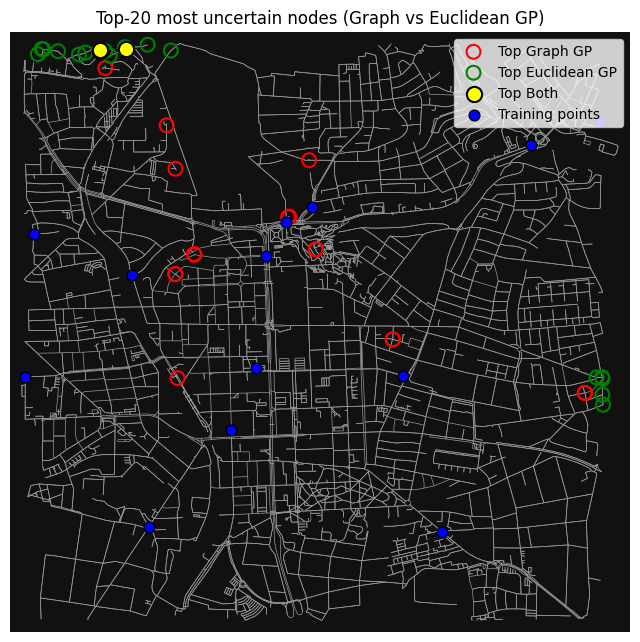

In [153]:
N_top = 20

# top N for Graph GP
top_graph_idx = node_xy_plot["std_graph_orig"].nlargest(N_top).index
top_graph_nodes = node_xy_plot.loc[top_graph_idx]

# top N for Euclidean GP
top_euc_idx = node_xy_plot["std_euc"].nlargest(N_top).index
top_euc_nodes = node_xy_plot.loc[top_euc_idx]

# optional: find common nodes in both top-N lists
common_nodes_idx = top_graph_idx.intersection(top_euc_idx)
common_nodes = node_xy_plot.loc[common_nodes_idx]

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)

# graph GP top N nodes
ax.scatter(
    top_graph_nodes["x"], top_graph_nodes["y"],
    facecolors="none", edgecolors="red",
    s=100, label="Top Graph GP", linewidths=1.5
)

# euclidean GP top N nodes
ax.scatter(
    top_euc_nodes["x"], top_euc_nodes["y"],
    facecolors="none", edgecolors="green",
    s=100, label="Top Euclidean GP", linewidths=1.5
)

# common top N nodes
if not common_nodes.empty:
    ax.scatter(
        common_nodes["x"], common_nodes["y"],
        facecolors="yellow", edgecolors="black",
        s=120, label="Top Both", linewidths=1.5
    )

# training points as reference
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="blue", edgecolors="black",
    s=60, label="Training points"
)

ax.set_title(f"Top-{N_top} most uncertain nodes (Graph vs Euclidean GP)")
ax.legend(loc="upper right")
plt.show()


### Optional: Hybrid GP

In [154]:
pred_mean_hybrid = pred_mean_euc + pred_mean_graph
pred_var_hybrid  = pred_std_euc**2 + pred_std_graph**2
pred_std_hybrid  = np.sqrt(pred_var_hybrid)

node_xy_plot["mean_hybrid"] = (
    node_xy_plot["mean_euc"] +
    node_xy_plot["mean_graph_orig"]
)

node_xy_plot["std_hybrid"] = np.sqrt(
    node_xy_plot["std_euc"]**2 +
    node_xy_plot["std_graph_orig"]**2
)


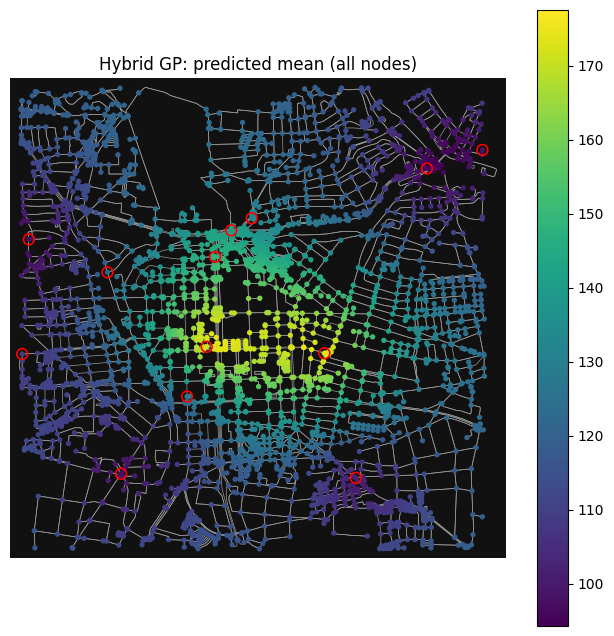

In [155]:
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)

sc = ax.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["mean_hybrid"], s=8)

ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)

plt.colorbar(sc, ax=ax)
ax.set_title("Hybrid GP: predicted mean (all nodes)")
plt.show()

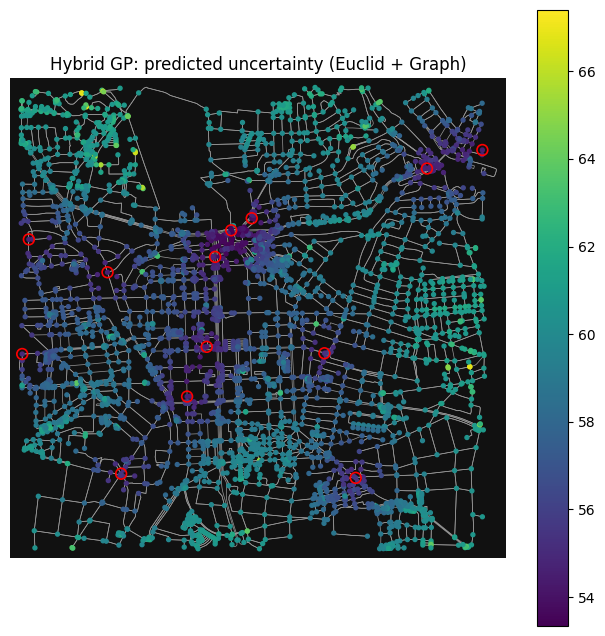

In [156]:
# plot hybrid sd
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5)

sc = ax.scatter(
    node_xy_plot["x"],
    node_xy_plot["y"],
    c=node_xy_plot["std_hybrid"],
    s=8
)

ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    facecolors="none",
    edgecolors="red",
    s=60,
    linewidths=1.2,
    zorder=10
)

plt.colorbar(sc, ax=ax)
ax.set_title("Hybrid GP: predicted uncertainty (Euclid + Graph)")
plt.show()


In [157]:
N_top = 20
top_uncert_hybrid = node_xy_plot.nlargest(N_top, "std_hybrid")

top_uncert_euc   = set(node_xy_plot.nlargest(N_top, "std_euc").index)
top_uncert_graph = set(node_xy_plot.nlargest(N_top, "std_graph_orig").index)
top_uncert_hyb   = set(top_uncert_hybrid.index)

print("Euclid ∩ Graph:", len(top_uncert_euc & top_uncert_graph))
print("Hybrid ∩ Euclid:", len(top_uncert_hyb & top_uncert_euc))
print("Hybrid ∩ Graph:", len(top_uncert_hyb & top_uncert_graph))


Euclid ∩ Graph: 3
Hybrid ∩ Euclid: 3
Hybrid ∩ Graph: 9


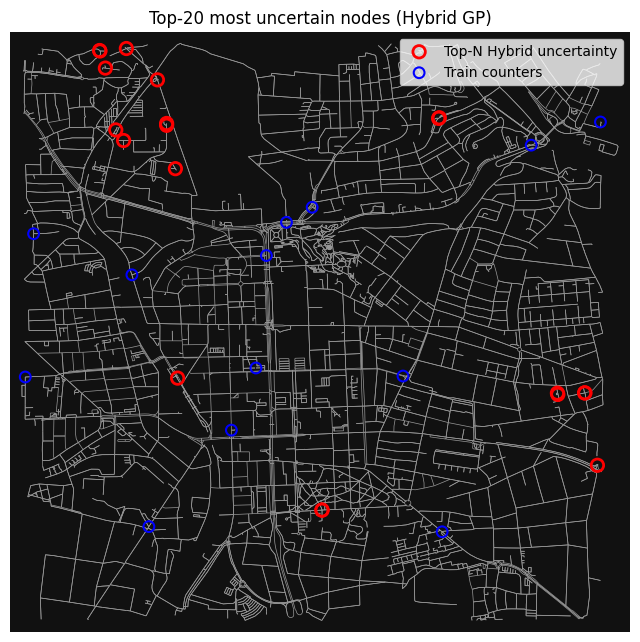

In [158]:
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    node_size=0,
    edge_linewidth=0.5
)

ax.scatter(
    top_uncert_hybrid["x"],
    top_uncert_hybrid["y"],
    s=80,
    facecolors="none",
    edgecolors="red",
    linewidths=2,
    label="Top-N Hybrid uncertainty"
)

# Trainingspunkte
ax.scatter(
    node_xy_plot.iloc[train_node_idx]["x"],
    node_xy_plot.iloc[train_node_idx]["y"],
    s=60,
    facecolors="none",
    edgecolors="blue",
    linewidths=1.5,
    label="Train counters"
)

ax.set_title(f"Top-{N_top} most uncertain nodes (Hybrid GP)")
ax.legend()
plt.show()
